In [22]:
import os, sys
import pandas as pd
import numpy as np
import json
import string
from itertools import compress

from omni.nlp import TextProcessing

from tensorflow.python.keras.models import load_model

from tensorflow.python import keras
from tensorflow.python.keras.utils import CustomObjectScope

import tensorflow as tf

In [29]:
from tqdm import tqdm

In [57]:
from tensorflow.python.keras import backend as K

In [23]:
dataset_validate_metadata_invalid_keys = ["length", "width", "weight", "cubicweight", "height", "sac", "garantia do fabricante", "codigo de relacionamento", "categoria google", "codigo do produto", "codigo de cor", "importante", "nao inclui", "video", "medidas", "codigo de barras", "peso", "prazo", "garantia", "altura", "quantidade", "garantia do fornecedor", "codigo do fornecedor", "dimensoes do produto", "youtube", "dimensoes", "peso do produto", "atendimento", "recomendacoes de uso", "altura do produto", "rbn", "ean"]
dataset_validate_metadata_char_max = 30

import unidecode

from bs4 import BeautifulSoup

translator = str.maketrans('', '', string.punctuation)
keys_translator = list(translator.keys())
key_to_change = [x == '-' for x in string.punctuation]
for key in list(compress(keys_translator, key_to_change)):
    translator[key] = " "

In [3]:
# class Attention_Bahdanau(tf.keras.Model):
class Attention_Bahdanau(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention_Bahdanau, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, inputs, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(inputs[0]) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * inputs[0]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(Attention_Bahdanau, self).get_config()
        config.update({
            'units': self.units
        })
        return config

In [4]:
class Attention_Bahdanau(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention_Bahdanau, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        #return super(Attention_Bahdanau, self).get_config()
        config = super(Attention_Bahdanau, self).get_config()
        config.update({
            'units': self.units
        })
        return config

In [5]:
filepath_model = 'entity_extractor_prod_model.h5'

In [6]:
filepath_niche_substantive_2_int = "sample_classifier_model_2020-06-24-19-55_niche_substantive_string_to_int.json"
filepath_word2vec_vocab_2_int = "sample_word2vec_2020-06-23-03-58_map.json"

In [7]:
with open(filepath_niche_substantive_2_int) as json_file:
    niche_substantive_2_int = json.load(json_file)

In [8]:
int_2_niche_substantive  = dict(
    (i, niche_substantive) for niche_substantive, i in niche_substantive_2_int.items())

In [9]:
with open(filepath_word2vec_vocab_2_int) as json_file:
    vocab_2_int = json.load(json_file)

In [10]:
with CustomObjectScope({'Attention_Bahdanau': Attention_Bahdanau}):
    model = load_model(filepath_model, compile=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      43838200    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 100, 1000),  2204000     embedding[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1000)         0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [12]:
df_data = pd.read_csv("dftrain500COLAB.csv", sep=";", error_bad_lines=False)

In [13]:
df_data.head()

,entity,name,structured_metadata,link,id,train,rand
0,ferramentas|Amortecedor de Vibração,Vibra Stop VS 2 1/4 - Vibra-stop,"{""Template de Produto"": ""unidade""}",8amp-https://a-static.mlcdn.com.br/618x463/vib...,8amp-httpsa-static.mlcdn.com.br618x463vibra-st...,1,0.045322
1,automotivos|Suporte Automotivo para Celular,Suporte veicular para smartphone - Multilaser ...,"{""height"": ""0.2"", ""weight"": ""0.4"", ""length"": ""...",33amp-http://shopfacil.vteximg.com.br/arquivos...,33amp-httpshopfacil.vteximg.com.brarquivosids4...,1,0.047454
2,automotivos|Suporte Automotivo para Celular,Kit MP3 Player Automotivo Shutt Montana BT Com...,"{""Modelo Ve\u00edculo"": ""Universal"", ""Ano Ve\u...",27amp-http://connectparts.vteximg.com.br/arqui...,27amp-httpconnectparts.vteximg.com.brarquivosi...,1,0.048190
3,mercado|Kit de Shampoo,Kit Shampoo Hidratante Fluido Protetor Fluido ...,{},https://a-static.mlcdn.com.br/618x463/kit-sham...,httpsa-static.mlcdn.com.br618x463kit-shampoo-h...,1,0.052305
4,automotivos|Borracha Automotiva,Borracha da Porta Logus Escort Verona 1993 a 2...,"{""Qual a pe\u00e7a?"": ""Borracha da Porta""}",18amp-https://a-static.mlcdn.com.br/618x463/bo...,18amp-httpsa-static.mlcdn.com.br618x463borrach...,1,0.053230


In [14]:
df_data.shape

(14836, 7)

In [16]:
#==================================================
#Functions

def text_preprocessing(txt):
    nlp = TextProcessing()
    txt = nlp.preprocess_str(txt=txt, clean_html=False, explode_digits=False)
    #txt = nlp.preprocess_str(txt=txt, clean_html=False)
    txt = txt.translate(translator)

    return txt

def validate_metadata_apply(metadata_dict, verbose = 0):

    # getting each metadata key
    new_label_data = {}
    empty_data = ['-', 'nan']
    # char_max = 50
    try:
        # print('conteudo: ' + row[structured_column])
        label_data = json.loads(metadata_dict)
        for item in label_data:
            if unidecode.unidecode(item).lower() not in dataset_validate_metadata_invalid_keys:
                #print(item)
                value = label_data.get(item)

                # clean html tags
                value = BeautifulSoup(value, 'lxml').get_text(" ", strip=True)
                #print(value)

                # exclude empty values
                if value in empty_data:
                    value = ''

                if 0 < len(str(value)) < dataset_validate_metadata_char_max:
                    new_label_data[item] = value

                #print(new_label_data)
                # else:
                # print('Long value :' + item + ' : '+ str(value))
            # else:
            # print('Invalid key : ' + item)

    except:
        if verbose > 2:
            logging.info('Sample with not valid json')

    return new_label_data

def convert_dict_metadata_text_lower(dict_metadata):
    return text_preprocessing(json.dumps(validate_metadata_apply(dict_metadata), ensure_ascii=False))

In [ ]:
def convert_tokens_to_charvec_timeframes(dataframe=None, column_selected=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):

    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 256

    dataX_vec = np.zeros([dataframe.shape[0], max_length, vectors_dim], dtype='float16')

    print(dataX_vec.shape)
    
    i = 0
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        seq = 0
        txt = str(row[column_selected])
        tokens = list(txt.split(" "))
        for item in tokens:
            if seq < max_length:
                # Evaluate a word
                word_vec = get_char_embedding_from_word(word=item, model_emb=embedding_model, char_to_int_dict=char_to_int_dict,
                                                        max_length=char_max_length)
                dataX_vec[i, seq, :] = word_vec
            else:
                break
            seq = seq + 1
        i = i + 1

    return dataX_vec

In [24]:
#Pre processing txt
df_data['name_process'] = df_data['name'].swifter.apply(text_preprocessing)

In [25]:
df_data['structured_metadata_process'] = df_data['structured_metadata'].swifter.apply(convert_dict_metadata_text_lower)

/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://drive.google.com/drive/folders/0B6iVbQpqlyD2aWJmZUF2dTVzSU0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://drive.google.com/file/d/1HuoXi4smYAobC0rPiOxAjLiymz_6nFJq/view" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://drive.google.com/open?id=0B6iVbQpqlyD2d21ZSzFzLVB6OE

/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://youtu.be/ELftHEc8zcY" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://youtu.be/cmlQBtxw6xA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://www.youtube.com/watch?v=dKIU2CmEOYc&amp;feature=em-subs_digest" looks like a URL. Beautiful Soup is not an HTTP client. You should pr

/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "http://ca2.monitoraudiocdn.com/downloads/brochure/Bronze-Brochure-2015-LR.pdf?mtime=20150518164428" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://youtu.be/o36QTchjJ6c" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/envs/entity-extractor-prod/lib/python3.6/site-packages/bs4/__init__.py:357: UserWarning: "https://www.youtube.com/watch?v=w5xccWGmqBU" looks like a URL. Beautifu

In [27]:
df_data['name_process']

0                           vibra stop vs 2 1 4 vibra stop
1        suporte veicular para smartphone multilaser ac275
2        kit mp3 player automotivo shutt montana bt com...
3        kit shampoo hidratante fluido protetor fluido ...
4        borracha da porta logus escort verona 1993 a 2...
5        suporte universal veicular para smartphone par...
6        bandeja perfect inferior direito honda city e ...
7        fechadura porta logus pointer 93 96 mecanica u...
8        esmalte gel ultra brilho esmalte gel ultra bri...
9        esmalte gel ultra brilho esmalte gel ultra bri...
10       fechadura dianteira escort 93 96 logus pointer...
11       fechadura porta escort 1997 a 2002 diant ld pr...
12                  capa para sousplat coqueiro decorafast
13       kit shampoo 2 em 1 grandes marcas dc batman vs...
14       bandeja dianteira direita palio 96 02 siena 96...
15       almofada maleta para cachorro m preta fabrica pet
16       conjunto com zirconia preta redonda 6 mm joia .

In [30]:
input_texts = []
for ind, row in tqdm(df_data.iterrows(), total = df_data.shape[0]):
    input_texts.append('{} {}'.format(row['name_process'], row['structured_metadata_process']))


100%|██████████| 14836/14836 [00:02<00:00, 5113.06it/s]


In [31]:
input_texts

['vibra stop vs 2 1 4 vibra stop template de produto unidade',
 'suporte veicular para smartphone multilaser ac275 ',
 'kit mp3 player automotivo shutt montana bt com controle  suporte veicular para celular universal modelo veiculo universal ano veiculo universal montadora universal',
 'kit shampoo hidratante fluido protetor fluido iluminador sol mar piscina acquaflora ',
 'borracha da porta logus escort verona 1993 a 2002 pointer ka fiesta disk bor qual a peca borracha da porta',
 'suporte universal veicular para smartphone para entrada de ar ac275 multilaser marca multilaser',
 'bandeja perfect inferior direito honda city e new fit bdj2032 montadora honda veiculos city',
 'fechadura porta logus pointer 93 96 mecanica universal side esquerdo motorista',
 'esmalte gel ultra brilho esmalte gel ultra brilho cabernet 11 ml apresentacao dmp esmaltess subcategoria dmp unhas faixa etaria dmp adulto tipo de produto dmp gel escolha o volume 11 ml tamanho dmp 11 ml exibe textura sim categoria d

In [34]:
def convert_text_tokens_to_word2vec_int_vocab(txt=None, max_length=None, word_to_int_dict=None):
    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 100
    
    dataX_vec = np.zeros([1, vectors_dim])
    
    tokens = list(txt.split(" "))
    seq = 0
    for item in tokens:
        if item in word_to_int_dict.keys():
            if seq < max_length:
                # Evaluate a word

                dataX_vec[0, seq] = word_to_int_dict[item]
            else:
                    break
            seq = seq + 1
    return dataX_vec

In [37]:
vec_text_w2v_ints = convert_text_tokens_to_word2vec_int_vocab(txt = input_texts[0], max_length=100, word_to_int_dict=vocab_2_int)


In [39]:
class_predict = model.predict(vec_text_w2v_ints)

In [70]:
classe = int_2_niche_substantive[np.argmax(class_predict)]

In [45]:
df_data.iloc[0]

entity                                       ferramentas|Amortecedor de Vibração
name                                            Vibra Stop VS 2 1/4 - Vibra-stop
structured_metadata                           {"Template de Produto": "unidade"}
link                           8amp-https://a-static.mlcdn.com.br/618x463/vib...
id                             8amp-httpsa-static.mlcdn.com.br618x463vibra-st...
train                                                                          1
rand                                                                   0.0453215
name_process                                      vibra stop vs 2 1 4 vibra stop
structured_metadata_process                          template de produto unidade
Name: 0, dtype: object

In [46]:
model.layers

In [48]:
model.layers[1].output

<tf.Tensor 'embedding/embedding_lookup/Identity_1:0' shape=(?, 100, 50) dtype=float32>

In [49]:
encoder_w2v_inputs = model.input[0] #input_2

embedd_w2v = model.layers[1]

embedd_w2v_out = embedd_w2v(encoder_w2v_inputs)

encoder_w2v = model.layers[2]
encoder_w2v_outputs = encoder_w2v(embedd_w2v_out)

concat_layer = model.layers[3]
intermed_layer =concat_layer(encoder_w2v_outputs)

classifier_model_intermed_layer = ModelKeras(inputs=[encoder_w2v_inputs],
                                   outputs=[intermed_layer])

ValueError: Input 0 of layer bidirectional is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [100, 50]

In [52]:
embedd_w2v_out.shape

TensorShape([Dimension(100), Dimension(50)])

In [53]:
encoder_w2v_inputs.shape

TensorShape([Dimension(100)])

In [63]:

def get_layer_outputs(model, layer_name, input_data, learning_phase=1):
    outputs   = [layer.output for layer in model.layers if layer_name in layer.name]
    layers_fn = K.function([model.input, K.learning_phase()], outputs)
    return [layers_fn([input_data,learning_phase])][0]

outs = get_layer_outputs(model, 'attention__bahdanau', vec_text_w2v_ints, 0)

In [66]:
(context_vector, attention_weights) = outs[0]

In [68]:
context_vector.shape

(1, 1000)

In [73]:
import matplotlib.pyplot as plt

def plot_attention_weights2(encoder_inputs, attention_weights, classe):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    attention_mat = attention_weights[0]
    
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels(classe)
    ax.set_yticklabels([inp if inp != 0 else "<Res>" for inp in encoder_inputs.split(' ')])

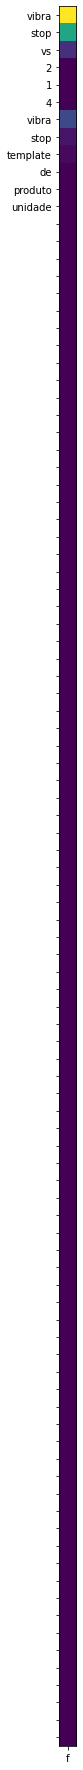

In [74]:
plot_attention_weights2(input_texts[0], attention_weights, classe)

In [77]:
predict = []
context_vector_arrays = []
for seq_index in tqdm(range(len(input_texts)), total=len(input_texts)):
    vec_text_w2v_ints = convert_text_tokens_to_word2vec_int_vocab(txt = input_texts[seq_index], max_length=100, word_to_int_dict=vocab_2_int)
    class_predict = model.predict(vec_text_w2v_ints)
    classe = int_2_niche_substantive[np.argmax(class_predict)]
    (context_vector, attention_weights) = get_layer_outputs(model, 'attention__bahdanau', vec_text_w2v_ints, 0)[0]
    predict.append(classe)
    context_vector_arrays.append(context_vector)
    

 69%|██████▉   | 10269/14836 [3:26:20<1:53:36,  1.49s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
len(context_vector_arrays)

14836

In [15]:
df_data.columns

Index(['entity', 'name', 'structured_metadata', 'link', 'id', 'train', 'rand'], dtype='object')

In [80]:
df_offers_intermediate_layer = pd.DataFrame()

In [81]:
df_offers_intermediate_layer['_id'] = df_data.id.values.tolist()
df_offers_intermediate_layer['name'] = df_data.name.values.tolist()
df_offers_intermediate_layer['structured_metadata'] = df_data.structured_metadata.values.tolist()
df_offers_intermediate_layer['link'] = df_data.link.values.tolist()
df_offers_intermediate_layer['entity'] = df_data.entity.values.tolist()
df_offers_intermediate_layer['train'] = df_data.train.values.tolist()
df_offers_intermediate_layer['rand'] = df_data.rand.values.tolist()

In [82]:
df_offers_intermediate_layer['intermed_layer'] = context_vector_arrays

In [83]:
df_offers_intermediate_layer['predict'] = predict

In [84]:
df_offers_intermediate_layer.head()

,_id,name,structured_metadata,link,entity,train,rand,intermed_layer,predict
0,8amp-httpsa-static.mlcdn.com.br618x463vibra-st...,Vibra Stop VS 2 1/4 - Vibra-stop,"{""Template de Produto"": ""unidade""}",8amp-https://a-static.mlcdn.com.br/618x463/vib...,ferramentas|Amortecedor de Vibração,1,0.045322,"[[0.007611258, 0.19828627, 0.460832, 0.6787169...",ferramentas|Amortecedor de Vibração
1,33amp-httpshopfacil.vteximg.com.brarquivosids4...,Suporte veicular para smartphone - Multilaser ...,"{""height"": ""0.2"", ""weight"": ""0.4"", ""length"": ""...",33amp-http://shopfacil.vteximg.com.br/arquivos...,automotivos|Suporte Automotivo para Celular,1,0.047454,"[[0.0, 0.76132107, -0.69890445, -0.8534734, -0...",automotivos|Suporte Automotivo para Celular
2,27amp-httpconnectparts.vteximg.com.brarquivosi...,Kit MP3 Player Automotivo Shutt Montana BT Com...,"{""Modelo Ve\u00edculo"": ""Universal"", ""Ano Ve\u...",27amp-http://connectparts.vteximg.com.br/arqui...,automotivos|Suporte Automotivo para Celular,1,0.048190,"[[0.049122706, 0.069252655, -0.055671617, -0.2...",automotivos|Suporte Automotivo para Celular
3,httpsa-static.mlcdn.com.br618x463kit-shampoo-h...,Kit Shampoo Hidratante Fluido Protetor Fluido ...,{},https://a-static.mlcdn.com.br/618x463/kit-sham...,mercado|Kit de Shampoo,1,0.052305,"[[-0.29936466, 0.31971875, -0.011315467, 0.168...",cosmeticos|Shampoo
4,18amp-httpsa-static.mlcdn.com.br618x463borrach...,Borracha da Porta Logus Escort Verona 1993 a 2...,"{""Qual a pe\u00e7a?"": ""Borracha da Porta""}",18amp-https://a-static.mlcdn.com.br/618x463/bo...,automotivos|Borracha Automotiva,1,0.053230,"[[0.5008322, -0.029775385, 0.37853014, 0.15255...",papelaria_escritorio|Borracha


In [86]:
df_offers_intermediate_layer.to_pickle('entity_prod_model_offers_intermediate_layer_predict.csv')

In [87]:
df0 = pd.read_pickle('entity_prod_model_offers_intermediate_layer_predict.csv')

In [88]:
df0.iloc[0].intermed_layer[0].shape

(1000,)

In [90]:
2398/3673

0.6528723114620202